In [1]:
import tensorflow.compat.v2 as tf
import pandas as pd
import numpy as np
import functools

import data_util_val

In [6]:
def build_input_fn(global_batch_size):
    #Build input function.
    #Args:
    #    global_batch_size: Global batch size.
    #Returns:
    #    A function that accepts a dict of params and returns a tuple of images and
    #    features, to be used as the input_fn in TPUEstimator.
    def _input_fn_(input_context):
        #Inner input function
        batch_size = input_context.get_per_replica_batch_size(global_batch_size)
        #logging.info('Global batch size: %d', global_batch_size)
        #logging.info('Per-replica batch size: %d', batch_size)
        preprocess_fn_finetune = get_preprocess_fn()
        num_classes = 5

        def map_fn(image, label):
            #image = preprocess_fn_finetune(image)
            #xs = []
            #for _ in range(2):  # Two transformations
            #    xs.append(preprocess_fn_finetune(image))
            image = image
            label = tf.one_hot(label, num_classes)
            return image, label

        #logging.info('Using Astro pretrain data')
        dataset = get_data_test()

        if input_context.num_input_pipelines > 1:
            dataset = dataset.shard(input_context.num_input_pipelines, input_context.input_pipeline_id)

        dataset = dataset.map(map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

    return _input_fn_

def build_distributed_dataset(batch_size, strategy):
    input_fn = build_input_fn(batch_size)
    return strategy.experimental_distribute_datasets_from_function(input_fn)

def get_preprocess_fn():
    #Get function that accepts an image and returns a preprocessed image
    return functools.partial(
        data_util_val.preprocess_image,
        height = 330,
        width= 330)


def get_data_test():
    #logging.info('Loading Astro test data')
    data_dir = 'imagenes_clasificadas_nair/'
    def read_images(image_file, label):
        image = tf.io.read_file(data_dir + image_file)
        image = tf.image.decode_jpeg(image, channels = 3)
        return image, label
    
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    df = pd.read_csv('nair_unbalanced_train.csv')
    file_paths = df['name'].values
    labels = df['new_class'].values
    labels = tf.convert_to_tensor(labels, dtype=tf.int64)
    ds_test = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds_test = ds_test.map(read_images, num_parallel_calls =AUTOTUNE)
    return ds_test

def get_number_of_images(path_to_csv):
    df = pd.read_csv(path_to_csv)
    return df.shape[0]

In [3]:
strategy = tf.distribute.MirroredStrategy()
ds = build_distributed_dataset(24, strategy)
iterator = iter(ds)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Instructions for updating:
rename to distribute_datasets_from_function


In [4]:
#R152_sk1_x3
saved_model = tf.saved_model.load('saved_model/26077/')

In [7]:
representations_list = []
#kmeans = MiniBatchKMeans(n_clusters=5)
for images, labels in iterator:
    representation = saved_model(images, trainable=False)['final_avg_pool']
    representation = representation.numpy()
    #kmeans.partial_fit(representation)
    representations_list.append(representation)

ValueError: Could not find matching function to call loaded from the SavedModel. Got:
  Positional arguments (2 total):
    * Tensor("inputs:0", shape=(24, 330, 330, 6), dtype=float32)
    * False
  Keyword arguments: {}

Expected these arguments to match one of the following 2 option(s):

Option 1:
  Positional arguments (2 total):
    * TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='inputs')
    * True
  Keyword arguments: {}

Option 2:
  Positional arguments (2 total):
    * TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='inputs')
    * False
  Keyword arguments: {}

In [7]:
representations_list

[array([[0.88684976, 0.504726  , 0.        , ..., 0.64620876, 0.559335  ,
         0.9405494 ],
        [0.6272679 , 0.87269723, 0.        , ..., 0.5072316 , 0.4818604 ,
         1.1392236 ],
        [0.40689158, 0.29079586, 0.        , ..., 0.742485  , 0.671394  ,
         1.707101  ],
        ...,
        [0.4567352 , 1.0703105 , 0.        , ..., 0.63272095, 0.6221552 ,
         1.0841374 ],
        [0.11151449, 0.3771437 , 0.        , ..., 0.77005154, 0.8230908 ,
         1.0167558 ],
        [0.19769374, 0.10675877, 0.        , ..., 0.9054544 , 0.21682203,
         1.3564725 ]], dtype=float32),
 array([[0.9190136 , 0.67496705, 0.        , ..., 0.6554942 , 0.47123533,
         1.9040008 ],
        [0.69518816, 0.62950003, 0.        , ..., 0.65878963, 0.3428822 ,
         0.5742885 ],
        [0.81191474, 0.5131488 , 0.        , ..., 0.70240706, 0.6815611 ,
         2.029146  ],
        ...,
        [1.3469129 , 0.48673445, 0.        , ..., 0.6407833 , 0.76634717,
         2.3834264 

In [8]:
u = np.concatenate(np.array(representations_list, dtype=object), axis=0)

In [9]:
u = u.astype(np.float32)

In [10]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=5)

In [11]:
clustering.fit(u)

AgglomerativeClustering(n_clusters=5)

In [50]:
d = clustering.labels_

In [51]:
d

array([0, 1, 3, ..., 1, 1, 0])

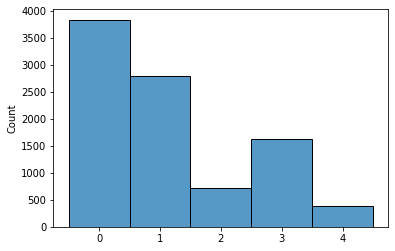

In [14]:
sns.histplot(d, discrete=True)
plt.show()

In [ ]:
u = pd.DataFrame(representations_list[0])
y = pd.DataFrame(representations_list[0])
u

In [ ]:
u.loc[ :] = y

In [ ]:
pd.concat((u,y)).reset_index(drop=True)

In [ ]:
io = pd.DataFrame(np.zeros((1,128)))
io.to_csv('representations_per_epoch.csv', index=False)

In [ ]:
x.loc[:,:] = j

In [ ]:
x

In [ ]:
for i in range(len(ll)):
    ll[i] = np.squeeze(ll[i])

In [1]:
!pip install -U scikit-learn
!pip install matplotlib
!pip install seaborn

     |████████████████████████████████| 24.9 MB 224 kB/s eta 0:00:01
     |████████████████████████████████| 303 kB 368 kB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 331 kB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 753 kB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 323 kB/s eta 0:00:01
     |████████████████████████████████| 285 kB 1.5 MB/s eta 0:00:01


In [6]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import Birch
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

In [ ]:
ll

In [ ]:
arr = np.array(ll)

In [ ]:
arr.shape

In [ ]:
arr[1].shape

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=5).fit_predict(u)#Birch(n_clusters=5).fit_predict(arr)#KMeans(n_clusters=5, init='random', algorithm='full').fit(ll)

In [ ]:
d = kmeans.predict(u)

In [ ]:
u = u.astype(np.float32)

In [ ]:
u.shape

In [ ]:
m = kmeans

In [ ]:
sns.histplot(d, discrete=True)
plt.show()

In [ ]:
d

In [ ]:
m.shape

In [ ]:
c0 = np.where(m==0)
c1 = np.where(m==1)
c2 = np.where(m==2)
c3 = np.where(m==3)
c4 = np.where(m==4)

In [ ]:
clusters = [np.where(kmeans==c)[0].shape[0] for c in range(5)]

In [ ]:
max(clusters)

In [ ]:
clusters

In [ ]:
m

In [ ]:
print(c0[0].shape[0],c1[0].shape[0],c2[0].shape[0],c3[0].shape[0],c4[0].shape[0] )

In [ ]:
pseudolabels = pd.DataFrame(m)
pseudolabels

In [ ]:
df = pd.read_csv('nair_unbalanced_train.csv')
df['pseudolabels'] = pseudolabels
df

In [ ]:
majority = max(c0[0].shape[0],c1[0].shape[0],c2[0].shape[0],c3[0].shape[0],c4[0].shape[0])
majority
ratio0 = majority / c0[0].shape[0]
ratio1 = majority / c1[0].shape[0]
ratio2 = majority / c2[0].shape[0]
ratio3 = majority / c3[0].shape[0]
ratio4 = majority / c4[0].shape[0]

In [ ]:
df = df.sort_values(by=['new_class']).reset_index(drop=True)
df

In [ ]:
df0 = df[df['pseudolabels']==0]
df1 = df[df['pseudolabels']==1]
df2 = df[df['pseudolabels']==2]
df3 = df[df['pseudolabels']==3]
df4 = df[df['pseudolabels']==4]

In [ ]:
df4

In [ ]:
ss0 = df0.loc[df0.index.repeat(1 if ratio0 ==1 else round(ratio0)+1)]
ss1 = df1.loc[df1.index.repeat(1 if ratio1 ==1 else round(ratio1)+1)]
ss2 = df2.loc[df2.index.repeat(1 if ratio2 ==1 else round(ratio2)+1)]
ss3 = df3.loc[df3.index.repeat(1 if ratio3 ==1 else round(ratio3)+1)]
ss4 = df4.loc[df4.index.repeat(1 if ratio4 ==1 else round(ratio4)+1)]

In [ ]:
true0 = ss0['new_class'].to_numpy()
sns.histplot(true0, discrete=True)
plt.show()

In [ ]:
true1 = ss1['new_class'].to_numpy()
sns.histplot(true1, discrete=True)
plt.show()

In [ ]:
true2 = ss2['new_class'].to_numpy()
sns.histplot(true2, discrete=True)
plt.show()

In [ ]:
true3 = ss3['new_class'].to_numpy()
sns.histplot(true3, discrete=True)
plt.show()

In [ ]:
true4 = ss4['new_class'].to_numpy()
sns.histplot(true4, discrete=True)
plt.show()

In [ ]:
s0 = ss0.sample(n=3584, replace = True).reset_index(drop=True)
s1 = ss1.sample(n=3584,replace = True).reset_index(drop=True)
s2 = ss2.sample(n=3584,replace = True).reset_index(drop=True)
s3 = ss3.sample(n=3584,replace = True).reset_index(drop=True)
s4 = ss4.sample(n=3584,replace = True).reset_index(drop=True)

join = [s0,s1,s2,s3,s4]
join = pd.concat(join).reset_index(drop=True)

a = join['new_class'].to_numpy()
b = join['pseudolabels'].to_numpy()

In [ ]:
sns.histplot(a, discrete=True)
plt.show()

In [ ]:
sns.histplot(b, discrete=True)
plt.show()

In [ ]:
join

In [ ]:
d = [df[df['pseudolabels']==s].reset_index(drop=True) for s in range(5)]

In [ ]:
by_psudolabels = [df[df['pseudolabels']==label].reset_index(drop=True)
                        for label in range(5)]
by_psudolabels

In [ ]:
dd = []
for dataframe in d:
    ratio = majority/dataframe.shape[0]
    new_dataframe = dataframe.loc[dataframe.index.repeat(1 if ratio==1.0 else round(ratio)+1)]
    new_dataframe = new_dataframe.sample(n=majority).reset_index(drop=True)
    dd.append(new_dataframe)
del d

In [ ]:
dd = pd.concat(dd).reset_index(drop=True)
dd

In [ ]:
concat = pd.concat(dd).reset_index(drop=True)
concat = concat.sample(frac=1).reset_index(drop=True)
namess = concat['name'].to_numpy()
labels_true = concat['new_class'].to_numpy()
labels_fake = concat['pseudolabels'].to_numpy()
concat

In [ ]:
namess[0]

In [ ]:
plt.hist(labels_true, bins = 5)
plt.show()

In [ ]:
labels_true.shape

In [ ]:
plt.hist(labels_fake, bins = 5)
plt.show()

In [ ]:
pca = PCA(n_components=3).fit_transform(arr)

In [ ]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(pca[:,0], pca[:,1], pca[:,2], color = "blue")
plt.show()

In [ ]:
kmeans2 = KMeans(n_clusters=5, init='random').fit(pca)
plt.hist(kmeans.labels_, bins = 5)
plt.show()

In [ ]:
pca2 = PCA(n_components=2).fit_transform(arr)
labels = KMeans(5, random_state=0).fit_predict(pca2)
plt.scatter(pca2[:, 0], pca2[:, 1], c=labels,
            s=50, cmap='viridis');

In [ ]:
plt.hist(labels, bins = 5)
plt.show()

In [ ]:
tsn = TSNE(n_components=2, perplexity=50).fit_transform(arr)

In [ ]:
plt.scatter(tsn[:, 0], tsn[:, 1], c=labels,
            s=50, cmap='viridis');

In [ ]:
plt.hist(labels, bins = 5)
plt.show()

In [ ]:
df = pd.read_csv('nair_unbalanced_train.csv')
file_paths = df['name'].values
labels = df['new_class'].values

In [ ]:
sns.histplot(labels, discrete=True)
plt.show()

In [ ]:
df

In [ ]:
df.sort_values(by=['new_class'])

In [ ]:
d2 = df[df['new_class']==2]

In [ ]:
!pip install yellowbrick

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(arr)

In [ ]:
kmeans = KMeans(n_clusters=2).fit_predict(arr)
kmeans

In [ ]:
sns.histplot(kmeans, discrete=True)
plt.show()

In [ ]:
c0 = np.where(kmeans==0)
c1 = np.where(kmeans==1)

In [ ]:
print(c0[0].shape[0],c1[0].shape[0])

In [ ]:
pseudolabels = pd.DataFrame(kmeans)
df = pd.read_csv('nair_unbalanced_train.csv')
df['pseudolabels'] = pseudolabels
df

In [ ]:
df0 = df[df['pseudolabels']==0]
df1 = df[df['pseudolabels']==1]

In [ ]:
np.where(df0['new_class']==0)[0].shape

In [ ]:
ss = df0['pseudolabels'].to_numpy()
s = df1['pseudolabels'].to_numpy()

In [ ]:
d = np.where(df['pseudolabels']==0)
dd = arr[d[0]]
e = np.where(df['pseudolabels']==1)
ee = arr[e[0]]

In [ ]:
ee.shape

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(dd)

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(ee)

In [ ]:
km = KMeans(n_clusters=2).fit_predict(dd)
km

In [ ]:
sns.histplot(km, discrete=True)
plt.show()

In [ ]:
df['new_lbls'] = 0 
df['new_lbls'][d[0]] = km

In [ ]:
df

In [ ]:
km1 = KMeans(n_clusters=3).fit_predict(ee)
km1 = km1 + 2

In [ ]:
sns.histplot(km1, discrete=True)
plt.show()

In [ ]:
df['new_lbls'][e[0]] = km1
df

In [ ]:
c0 = np.where(df['new_lbls']==0)
c1 = np.where(df['new_lbls']==1)
c2 = np.where(df['new_lbls']==2)
c3 = np.where(df['new_lbls']==3)
c4 = np.where(df['new_lbls']==4)

In [ ]:
ratio0 = majority / c0[0].shape[0]
ratio1 = majority / c1[0].shape[0]
ratio2 = majority / c2[0].shape[0]
ratio3 = majority / c3[0].shape[0]
ratio4 = majority / c4[0].shape[0]

In [ ]:
df0 = df[df['new_lbls']==0]
df1 = df[df['new_lbls']==1]
df2 = df[df['new_lbls']==2]
df3 = df[df['new_lbls']==3]
df4 = df[df['new_lbls']==4]

In [ ]:
ss0 = df0.loc[df0.index.repeat(1 if ratio0 ==1 else round(ratio0)+1)]
ss1 = df1.loc[df1.index.repeat(1 if ratio1 ==1 else round(ratio1)+1)]
ss2 = df2.loc[df2.index.repeat(1 if ratio2 ==1 else round(ratio2)+1)]
ss3 = df3.loc[df3.index.repeat(1 if ratio3 ==1 else round(ratio3)+1)]
ss4 = df4.loc[df4.index.repeat(1 if ratio4 ==1 else round(ratio4)+1)]

In [ ]:
s0 = ss0.sample(n=3214, replace = True).reset_index(drop=True)
s1 = ss1.sample(n=3214,replace = True).reset_index(drop=True)
s2 = ss2.sample(n=3214,replace = True).reset_index(drop=True)
s3 = ss3.sample(n=3214,replace = True).reset_index(drop=True)
s4 = ss4.sample(n=3214,replace = True).reset_index(drop=True)

join = [s0,s1,s2,s3,s4]
join = pd.concat(join).reset_index(drop=True)

a = join['new_class'].to_numpy()
b = join['pseudolabels'].to_numpy()

In [ ]:
majority = max(c0[0].shape[0],c1[0].shape[0],c2[0].shape[0],c3[0].shape[0],c4[0].shape[0])
majority

In [ ]:
sns.histplot(a, discrete=True)
plt.show()

In [ ]:
r = sns.histplot(f, discrete=True)
plt.show()

In [ ]:
def get_new_ds(representations):

    representations = representations.numpy()

    pseudolabels = MiniBatchKMeans(n_clusters = 5).fit_predict(representations)
    cluster_length = [np.where(pseudolabels==c)[0].shape[0] for c in range(5)]
    larger_cluster_length = max(cluster_length)

    df = pd.read_csv('nair_unbalanced_train.csv')
    df['pseudolabels'] = pseudolabels

    by_psudolabels = [df[df['pseudolabels']==label].reset_index(drop=True)
                        for label in range(5)]

    extended_dataframes = []
    for dataframe in by_psudolabels:
        ratio = larger_cluster_length/dataframe.shape[0]
        extended_dataframe = dataframe.loc[dataframe.index.repeat(1 if ratio==1.0 else round(ratio)+1)]
        extended_dataframe = extended_dataframe.sample(n=larger_cluster_length).reset_index(drop=True)
        extended_dataframes.append(extended_dataframe)
    
    del by_psudolabels

    extended_dataframes = pd.concat(extended_dataframes).reset_index(drop=True)
    extended_dataframes = extended_dataframes.sample(frac=1).reset_index(drop=True)

    return extended_dataframes

In [20]:
o = iterator.get_next()

In [43]:
dz= o[0][1]

In [44]:
img1=dz[:,:,:3]
img2=dz[:,:,3:]

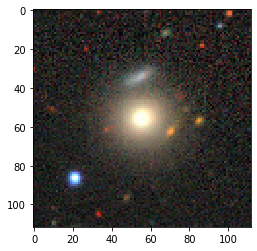

In [45]:
plt.imshow(img1, interpolation='nearest')
plt.show()

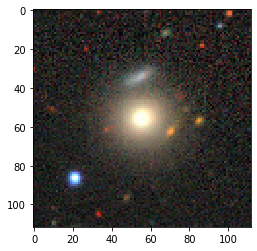

In [46]:
plt.imshow(img2, interpolation='nearest')
plt.show()

In [42]:
o

(<tf.Tensor: shape=(8, 112, 112, 6), dtype=float32, numpy=
 array([[[[0.08231555, 0.11680426, 0.1436271 , 0.08231555, 0.11680426,
           0.1436271 ],
          [0.06351721, 0.16572914, 0.13379243, 0.06351721, 0.16572914,
           0.13379243],
          [0.10361344, 0.07850447, 0.08522244, 0.10361344, 0.07850447,
           0.08522244],
          ...,
          [0.11715229, 0.13857341, 0.14732774, 0.11715229, 0.13857341,
           0.14732774],
          [0.13773616, 0.11122633, 0.10108372, 0.13773616, 0.11122633,
           0.10108372],
          [0.09682006, 0.16324787, 0.14966133, 0.09682006, 0.16324787,
           0.14966133]],
 
         [[0.09907703, 0.07580141, 0.10163832, 0.09907703, 0.07580141,
           0.10163832],
          [0.07105876, 0.18507175, 0.17628397, 0.07105876, 0.18507175,
           0.17628397],
          [0.09382676, 0.10385896, 0.10756984, 0.09382676, 0.10385896,
           0.10756984],
          ...,
          [0.03472957, 0.09186471, 0.11813546, 0.0347